In [1]:
!pip -q install gurobipy==11.0.3 # Colab에 Gurobi 설치
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.4 MB/s eta 0:00:00


In [2]:
# ---------------------------
# Sets
# ---------------------------
I = ["i1","i2","i3","i4","i5","i6"]        # 고객 집합
J = ["j1","j2","j3","j4"]        # 창고 집합
K = ["k1","k2","k3"]        # 공장 집합
L = ["A","B","C"]          # 제품 집합
T = [1,2,3]              # 기간 집합

Jc = {"j1"}            # 필수 창고 (1기부터 운영)
J0 = set(J) - Jc       # 선택 창고
Kc = {"k1"}            # 필수 공장
K0 = set(K) - Kc       # 선택 공장

t1, tT = min(T), max(T)   # 첫 기간, 마지막 기간

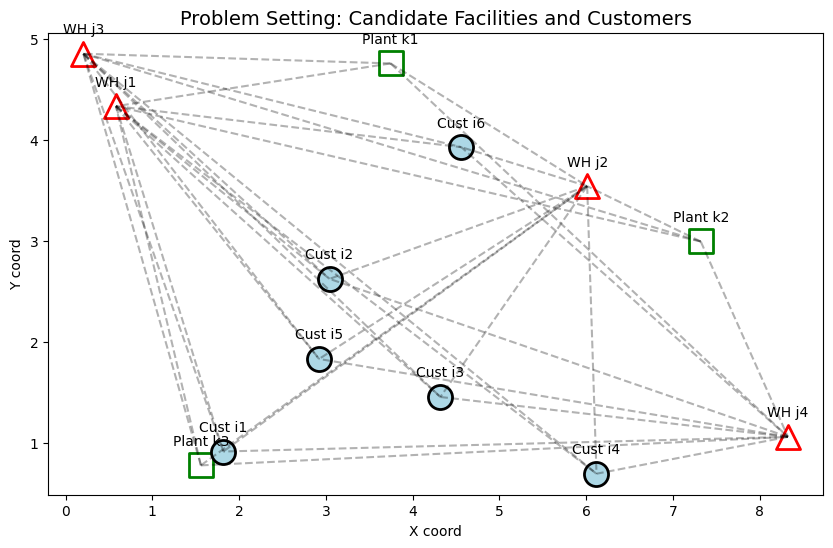

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. 랜덤 좌표 생성 (문제상황)
# -----------------------------
np.random.seed(42)
coords = {}
for k in K:
    coords[k] = np.random.rand(2) * [10, 5]
for j in J:
    coords[j] = np.random.rand(2) * [10, 5]
for i in I:
    coords[i] = np.random.rand(2) * [10, 5]

def plot_problem(coords, I, J, K):
    plt.figure(figsize=(10,6))

    # Plants
    for k in K:
        plt.scatter(*coords[k], s=300, c="white", edgecolors="green", marker="s", linewidths=2)
        plt.text(coords[k][0], coords[k][1]+0.2, f"Plant {k}", ha="center")

    # Warehouses
    for j in J:
        plt.scatter(*coords[j], s=300, c="white", edgecolors="red", marker="^", linewidths=2)
        plt.text(coords[j][0], coords[j][1]+0.2, f"WH {j}", ha="center")

    # Customers
    for i in I:
        plt.scatter(*coords[i], s=300, c="lightblue", edgecolors="black", marker="o", linewidths=2)
        plt.text(coords[i][0], coords[i][1]+0.2, f"Cust {i}", ha="center")

    # 연결선 (가능한 경로, 점선)
    for k in K:
        for j in J:
            x1,y1 = coords[k]; x2,y2 = coords[j]
            plt.plot([x1,x2],[y1,y2],'k--',alpha=0.3)
    for j in J:
        for i in I:
            x1,y1 = coords[j]; x2,y2 = coords[i]
            plt.plot([x1,x2],[y1,y2],'k--',alpha=0.3)

    plt.title("Problem Setting: Candidate Facilities and Customers", fontsize=14)
    plt.xlabel("X coord")
    plt.ylabel("Y coord")
    plt.show()

plot_problem(coords, I, J, K)


In [4]:
# ---------------------------
# Parameters
# ---------------------------
import numpy as np

np.random.seed(42)

# ---------------------------
# 고객 수요 d_{i l}^t
# ---------------------------
d = {}
total_demand = 0
for i in I:
    for l in L:
        for t in T:
            val = np.random.randint(5, 15)   # 각 고객-제품-기간 수요
            d[i,l,t] = val
            total_demand += val

print("총 수요량:", total_demand)

# ---------------------------
# 창고 용량 W_j^t
# ---------------------------
W = {}
warehouse_capacity_total = int(total_demand * 1.2)  # 총 수요의 120% 확보
cap_per_wh = warehouse_capacity_total // (len(J)*len(T))

for j in J:
    for t in T:
        W[j,t] = cap_per_wh

# ---------------------------
# 공장 용량 C_k^t
# ---------------------------
C = {}
plant_capacity_total = int(total_demand * 1.5)  # 총 수요의 150% 확보
cap_per_pl = plant_capacity_total // (len(K)*len(T))

for k in K:
    for t in T:
        C[k,t] = cap_per_pl

# ---------------------------
# 비용 (운송 + 운영)
# ---------------------------
c = {(i,j,l,t): round(np.random.uniform(1.0, 3.0),2)
     for i in I for j in J for l in L for t in T}   # 창고→고객
b = {(j,k,l,t): round(np.random.uniform(0.5, 2.0),2)
     for j in J for k in K for l in L for t in T}   # 공장→창고
f = {(j,t): np.random.randint(5, 10) for j in J for t in T}  # 창고 운영비
g = {(k,t): np.random.randint(8, 15) for k in K for t in T}  # 공장 운영비

# ---------------------------
# 최소 개수 정책
# ---------------------------
ND1, NDT = 1, 1    # 최소 창고 개수
NC1, NCT = 1, 1    # 최소 공장 개수


총 수요량: 518


In [5]:
# model 생성
m = Model()

# ---------------------------
# Decision Variables
# ---------------------------
x = m.addVars(I,J,L,T, vtype=GRB.CONTINUOUS, lb=0.0, name="x")                 # 고객 수요를 창고에서 얼마나 충족시키는지 (비율)
y = m.addVars(J,K,L,T, vtype=GRB.CONTINUOUS, lb=0.0, name="y")                 # 창고 용량을 공장이 얼마나 공급하는지 (비율)
u = m.addVars(J,T, vtype=GRB.BINARY, name="u")           # 창고 개폐 여부 (0/1)
v = m.addVars(K,T, vtype=GRB.BINARY, name="v")           # 공장 개폐 여부 (0/1)


Restricted license - for non-production use only - expires 2025-11-24


In [6]:
# ---------------------------
# 목적함수 (Objective)
#   총 비용 최소화:
#   운송비 (창고→고객, 공장→창고) + 운영비 (창고, 공장)
# ---------------------------
obj_wc = gp.quicksum(c[i,j,l,t]*d[i,l,t]*x[i,j,l,t] for i in I for j in J for l in L for t in T)
obj_pw = gp.quicksum(b[j,k,l,t]*W[j,t]*y[j,k,l,t] for j in J for k in K for l in L for t in T)
obj_wc_fix = gp.quicksum(f[j,t]*u[j,t] for j in J for t in T)
obj_pw_fix = gp.quicksum(g[k,t]*v[k,t] for k in K for t in T)
m.setObjective(obj_wc + obj_pw + obj_wc_fix + obj_pw_fix, GRB.MINIMIZE)


In [7]:
# ---------------------------
# 제약조건 (Constraints) (1)~(8)
# ---------------------------

# (1) 수요 충족: 각 고객-제품-기간 수요는 반드시 충족
for i in I:
    for l in L:
        for t in T:
            if d[i,l,t] > 0:
                m.addConstr(gp.quicksum(x[i,j,l,t] for j in J) >= 1,
                            name=f"(1)_demand[{i},{l},{t}]")

# (2) 창고 용량 제약
for j in J:
    for t in T:
        m.addConstr(gp.quicksum(d[i,l,t]*x[i,j,l,t] for i in I for l in L) <= W[j,t]*u[j,t],
                    name=f"(2)_wh_cap[{j},{t}]")

# (3) 창고 흐름 보존: 들어온 물량 ≥ 나간 물량
for j in J:
    for l in L:
        for t in T:
            m.addConstr(gp.quicksum(W[j,t]*y[j,k,l,t] for k in K) >=
                        gp.quicksum(d[i,l,t]*x[i,j,l,t] for i in I),
                        name=f"(3)_wh_flow[{j},{l},{t}]")

# (4) 공장 용량 제약
for k in K:
    for t in T:
        m.addConstr(gp.quicksum(W[j,t]*y[j,k,l,t] for j in J for l in L) <= C[k,t]*v[k,t],
                    name=f"(4)_pl_cap[{k},{t}]")

# (5) 최소 창고 개수 제약 (첫/마지막 기간)
m.addConstr(gp.quicksum(u[j,t1] for j in J) >= ND1, name="(5)_min_wh_first")
m.addConstr(gp.quicksum(u[j,tT] for j in J) >= NDT, name="(5)_min_wh_last")

# (6) 최소 공장 개수 제약 (첫/마지막 기간)
m.addConstr(gp.quicksum(v[k,t1] for k in K) >= NC1, name="(6)_min_pl_first")
m.addConstr(gp.quicksum(v[k,tT] for k in K) >= NCT, name="(6)_min_pl_last")

# (7) 창고 개폐 정책
for j in Jc:
    m.addConstr(u[j,t1] == 1, name=f"(7)_wh_start_open[{j}]")   # 필수 창고는 첫 기간에 반드시 열려야 함
    for t in T[:-1]:
        m.addConstr(u[j,t] >= u[j,t+1], name=f"(7)_wh_no_reopen[{j},{t}]")  # 닫히면 다시 못 엶
for j in J0:
    for t in T[:-1]:
        m.addConstr(u[j,t] <= u[j,t+1], name=f"(7)_wh_stay_open[{j},{t}]")  # 한번 열리면 계속 열려 있어야 함

# (8) 공장 개폐 정책
for k in Kc:
    m.addConstr(v[k,t1] == 1, name=f"(8)_pl_start_open[{k}]")   # 필수 공장은 첫 기간에 열려야 함
    for t in T[:-1]:
        m.addConstr(v[k,t] >= v[k,t+1], name=f"(8)_pl_no_reopen[{k},{t}]")
for k in K0:
    for t in T[:-1]:
        m.addConstr(v[k,t] <= v[k,t+1], name=f"(8)_pl_stay_open[{k},{t}]")

In [8]:
# ---------------------------
# 최적화 실행
# ---------------------------
m.optimize()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 131 rows, 345 columns and 929 nonzeros
Model fingerprint: 0x0ff0ac92
Variable types: 324 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1808.9100000
Presolve removed 6 rows and 2 columns
Presolve time: 0.00s
Presolved: 125 rows, 343 columns, 914 nonzeros
Variable types: 324 continuous, 19 integer (19 binary)

Root relaxation: objective 1.268132e+03, 162 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

In [9]:
# ---------------------------
# 결과 출력
# ---------------------------
print("\n목적함수 값 (총 비용):", round(m.objVal,3))

print("\n기간별 개설 창고:")
for t in T:
    print(f"t={t} ->", [j for j in J if u[j,t].X > 0.5])

print("\n기간별 개설 공장:")
for t in T:
    print(f"t={t} ->", [k for k in K if v[k,t].X > 0.5])

print("\n창고→고객 흐름:")
for t in T:
    for l in L:
        for j in J:
            served = sum(d[i,l,t]*x[i,j,l,t].X for i in I)
            if served > 1e-6:
                print(f"t={t}, 제품={l}, 창고={j}, 출고량={served:.2f}")

print("\n공장→창고 흐름:")
for t in T:
    for l in L:
        for k in K:
            for j in J:
                amount = W[j,t]*y[j,k,l,t].X
                if amount > 1e-6:
                    print(f"t={t}, 제품={l}, 공장={k} -> 창고={j}, 공급량={amount:.2f}")


목적함수 값 (총 비용): 1292.16

기간별 개설 창고:
t=1 -> ['j1', 'j2', 'j3', 'j4']
t=2 -> ['j1', 'j2', 'j3', 'j4']
t=3 -> ['j1', 'j2', 'j3', 'j4']

기간별 개설 공장:
t=1 -> ['k1', 'k3']
t=2 -> ['k1', 'k3']
t=3 -> ['k1', 'k2', 'k3']

창고→고객 흐름:
t=1, 제품=A, 창고=j2, 출고량=9.00
t=1, 제품=A, 창고=j3, 출고량=19.00
t=1, 제품=A, 창고=j4, 출고량=31.00
t=1, 제품=B, 창고=j2, 출고량=28.00
t=1, 제품=B, 창고=j3, 출고량=18.00
t=1, 제품=B, 창고=j4, 출고량=12.00
t=1, 제품=C, 창고=j1, 출고량=27.00
t=1, 제품=C, 창고=j2, 출고량=14.00
t=1, 제품=C, 창고=j3, 출고량=14.00
t=2, 제품=A, 창고=j3, 출고량=33.00
t=2, 제품=A, 창고=j4, 출고량=17.00
t=2, 제품=B, 창고=j1, 출고량=30.00
t=2, 제품=B, 창고=j2, 출고량=13.00
t=2, 제품=B, 창고=j3, 출고량=7.00
t=2, 제품=B, 창고=j4, 출고량=14.00
t=2, 제품=C, 창고=j1, 출고량=16.00
t=2, 제품=C, 창고=j2, 출고량=13.00
t=2, 제품=C, 창고=j3, 출고량=6.00
t=2, 제품=C, 창고=j4, 출고량=19.00
t=3, 제품=A, 창고=j1, 출고량=12.00
t=3, 제품=A, 창고=j2, 출고량=25.00
t=3, 제품=A, 창고=j3, 출고량=10.00
t=3, 제품=A, 창고=j4, 출고량=8.00
t=3, 제품=B, 창고=j1, 출고량=1.00
t=3, 제품=B, 창고=j2, 출고량=26.00
t=3, 제품=B, 창고=j4, 출고량=29.00
t=3, 제품=C, 창고=j1, 출고량=12.00
t=3, 제품=C, 창고=j3, 출고량=41.00


/tmp/ipython-input-1734119437.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(L))


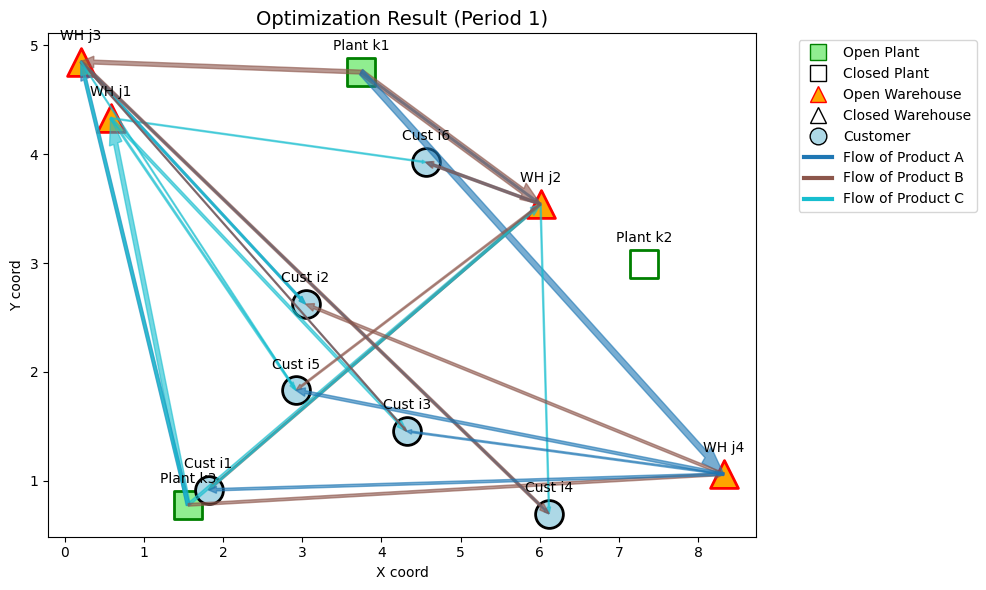

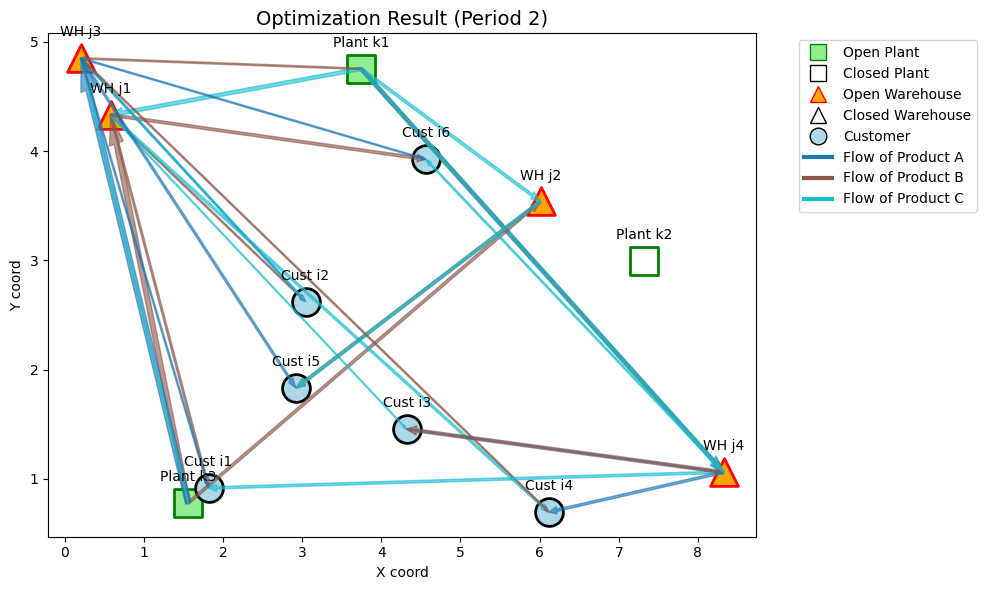

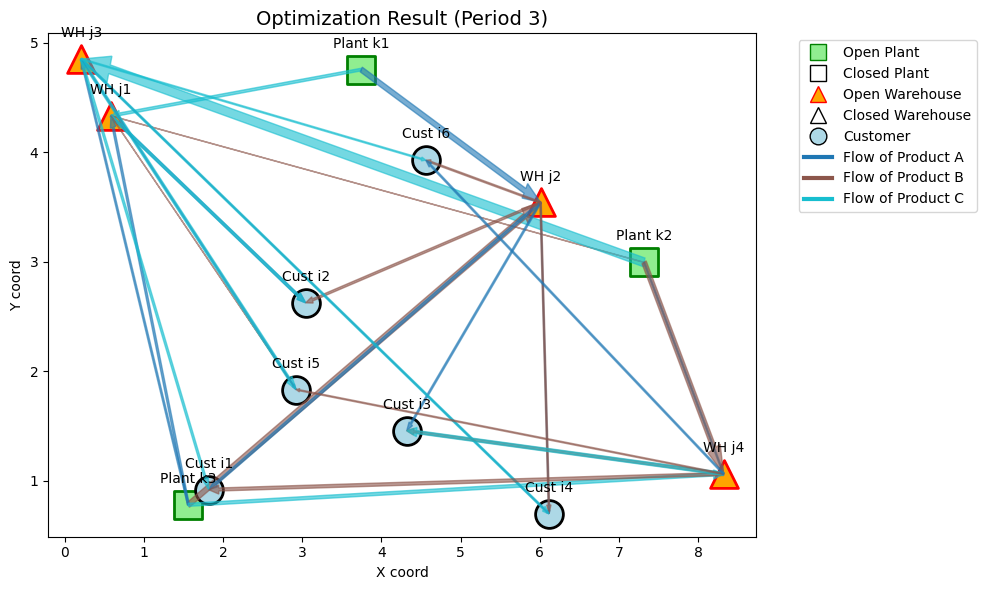

In [10]:
def plot_solution_map(t, I, J, K, L, u, v, x, y, d, W, coords):
    plt.figure(figsize=(10,6))

    # --- 노드 ---
    for k in K:
        chosen = v[k,t].X > 0.5
        plt.scatter(*coords[k], s=400, c="lightgreen" if chosen else "white",
                    edgecolors="green", marker="s", linewidths=2)
        plt.text(coords[k][0], coords[k][1]+0.2, f"Plant {k}", ha="center")

    for j in J:
        chosen = u[j,t].X > 0.5
        plt.scatter(*coords[j], s=400, c="orange" if chosen else "white",
                    edgecolors="red", marker="^", linewidths=2)
        plt.text(coords[j][0], coords[j][1]+0.2, f"WH {j}", ha="center")

    for i in I:
        plt.scatter(*coords[i], s=400, c="lightblue", edgecolors="black", marker="o", linewidths=2)
        plt.text(coords[i][0], coords[i][1]+0.2, f"Cust {i}", ha="center")

    # --- 품목별 색상 팔레트 ---
    import matplotlib.cm as cm
    cmap = cm.get_cmap("tab10", len(L))
    color_map = {l: cmap(idx) for idx,l in enumerate(L)}

    # --- 흐름: Plant→Warehouse ---
    for k in K:
        for j in J:
            for l in L:
                flow = W[j,t]*y[j,k,l,t].X
                if flow > 1e-6:
                    x1,y1 = coords[k]; x2,y2 = coords[j]
                    plt.arrow(x1, y1, x2-x1, y2-y1,
                              width=0.002*flow, color=color_map[l], alpha=0.6,
                              length_includes_head=True)

    # --- 흐름: Warehouse→Customer ---
    for j in J:
        for i in I:
            for l in L:
                flow = d[i,l,t]*x[i,j,l,t].X
                if flow > 1e-6:
                    x1,y1 = coords[j]; x2,y2 = coords[i]
                    plt.arrow(x1, y1, x2-x1, y2-y1,
                              width=0.002*flow, color=color_map[l], alpha=0.6,
                              length_includes_head=True)

    # --- 범례 ---
    legend_elements = [
        plt.Line2D([0],[0], marker='s', color='w', label='Open Plant',
                   markerfacecolor='lightgreen', markeredgecolor='green', markersize=12),
        plt.Line2D([0],[0], marker='s', color='w', label='Closed Plant',
                   markerfacecolor='white', markeredgecolor='black', markersize=12),
        plt.Line2D([0],[0], marker='^', color='w', label='Open Warehouse',
                   markerfacecolor='orange', markeredgecolor='red', markersize=12),
        plt.Line2D([0],[0], marker='^', color='w', label='Closed Warehouse',
                   markerfacecolor='white', markeredgecolor='black', markersize=12),
        plt.Line2D([0],[0], marker='o', color='w', label='Customer',
                   markerfacecolor='lightblue', markeredgecolor='black', markersize=12)
    ]
    for l in L:
        legend_elements.append(
            plt.Line2D([0],[0], color=color_map[l], lw=3, label=f"Flow of Product {l}")
        )

    # 범례를 오른쪽 밖에 표시
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    plt.title(f"Optimization Result (Period {t})", fontsize=14)
    plt.xlabel("X coord")
    plt.ylabel("Y coord")
    plt.tight_layout()
    plt.show()

# 실행: 시기별 결과
for t in T:
    plot_solution_map(t, I, J, K, L, u, v, x, y, d, W, coords)
